# 投票分类器

## 建立数据集

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

x, y = make_moons(n_samples=500, noise=0.30, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

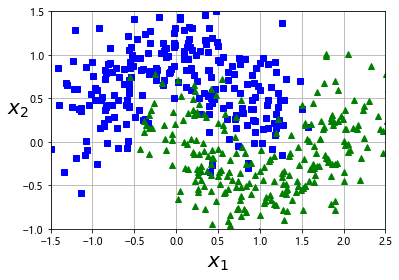

In [2]:
plot_dataset(x, y, [-1.5, 2.5, -1, 1.5])

## 集成算法

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')  # 硬投票法，软投票用'soft'
voting_clf.fit(x, y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

如果采用软投票（通过概率判断），还需设置SVC的超参数probability=True，但会减慢训练速度
```
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')  # 软投票
voting_clf.fit(x, y)
```

In [4]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


投票分类器略胜于所有单个分类器

# bagging和pasting（自助法）

```
bagging 是 bootstrap aggregating 的缩写，为有放回抽样（自举法），pasting为不放回抽样
即用多个模型在训练集抽样并训练，各自得出预测结果，再综合预测得出最终结果
```

## BaggingClassifier

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,  # 包含500个决策树
    max_samples=100, bootstrap=True, n_jobs=-1)  # 每次随机采样100个训练实例进行训练然后放回（不放回用bootstrap=False）
# n_jobs指示用多少CPU内核进行训练和预测（-1表示可用全部内核）
bag_clf.fit(x_train, y_train)
y_pred = bag_clf.predict(x_train)

## 包外评估（oob）

对于一个大小为S的样本，在S次抽样中，一个个体从未被抽到的概率是$(1-S^{-1})^S$， S趋于无穷时，概率为$e^{-1}=0.368$，因此大约有三分之一的数据不会被抽到，该部分数据称为$oob$，可以作为测试集

In [6]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, 
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(x_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [7]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.92

可见在训练集和预测集分数差不多

In [8]:
bag_clf.oob_decision_function_[:10, :]  # 查看概率  索引顺序为 行 列

array([[0.36046512, 0.63953488],
       [0.34319527, 0.65680473],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08510638, 0.91489362],
       [0.34554974, 0.65445026],
       [0.005     , 0.995     ],
       [0.97752809, 0.02247191],
       [0.97382199, 0.02617801]])

# 随机补丁和随机子空间

```
超参数max_feartures和bootstrap_features控制对特征进行采样，即保留全部实例而抽样特征
max_feartures=False, bootstrap_features=1.0 为随机补丁
max_feartures=Ture, bootstrap_features<1.0 为随机子空间法
```

# 随机森林

In [9]:
from sklearn.ensemble import RandomForestClassifier

rnd_cld = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
# 500棵决策树，最大叶子节点16，全部CPU可用
rnd_clf.fit(x_train, y_train)

y_pred_rf = rnd_clf.predict(x_test)

以下用`BaggingClassifier()`实现的随机森林与`RandomForestClassifier()`大致相同

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

## 极端随机树

`ExtraTreesClassifier()`可以创建一个极端随机树分类器，同理也有`ExtraTreesRegressior`

他们的效果好坏很难预先得知，只能通过尝试两种方法并且比较

## 特征重要性

随机森林便于快速了解哪些特征是真正重要的，`.feature_importances_`输出特征重要性

> Sklearn所有算法都可以输出特征重要性

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, socre in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, socre)

sepal length (cm) 0.09528555263213345
sepal width (cm) 0.022293624775266047
petal length (cm) 0.4542113889692266
petal width (cm) 0.4282094336233738


花瓣长度44%，花瓣宽度42%，而花萼长度相对不太重要

# 提升法（boosting）

将几个弱机器学习器结合成一个强学习器的任意集成方法，循环训练预测器，每一次都对其前序做出一些改正（更改实例和各模型权重），目前流行的方法是AdaBoost和梯度提升法

## AdaBoost

调整预测其权重和实例权重

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

SAMME 基于多类指数损失函数的逐步添加模拟器

SAMME.R 改为依赖概率

200个决策树

学习率0.5

每个决策树深度为1，即只有一个根节点和两个叶节点

> 如果过拟合，可以减少估算器数量，或提高估算器正则化程度

## 梯度提升

梯度树提升（DBRT）

In [14]:
import numpy as np
np.random.seed(42)
x = np.random.rand(100, 1) - 0.5
y = 3 * x[:, 0]**2 + 0.05 * np.random.randn(100)

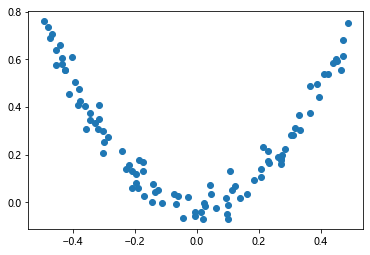

In [15]:
plt.scatter(x, y)
plt.show()

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(x, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

### 提前停止

```
使用staged_predict()方法，在训练的每个阶段都对集成的预测返回一个迭代器，通过测量每个训练阶段的验证误差，从而找到树的最优数量，最后使用最优树重新训练了一个GBRT集成
```

In [31]:
'''
训练完毕再找最小值
'''

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_val, y_train, y_val = train_test_split(x, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(x_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(x_val)]
best_n_estimators = np.argmin(errors) + 1 
# np.argmin(errors) 返回使得errors最小的下标，加一就是迭代器的次序，次序等于树的棵树

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=55)

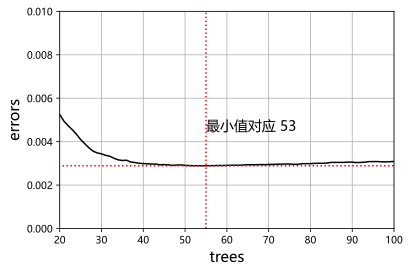

In [32]:
%config InlineBackend.figure_format = 'svg'
plt.plot(range(len(errors)), errors, 'k-')
plt.plot([best_n_estimators, best_n_estimators], [0, 0.05], 'r:')
plt.plot([0, 120], [min(errors), min(errors)], 'r:')
plt.axis([20,100,0,0.01])
plt.ylabel('errors',fontsize='15')
plt.xlabel('trees',fontsize='15')
plt.text(55, 0.0045, '最小值对应 53', fontsize='14')
plt.grid()
plt.show()

In [33]:
'''
训练中途停止
'''

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')

error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators  # 逐步增加树
    gbrt.fit(x_train, y_train)  # 训练
    y_pred = gbrt.predict(x_val)  # 预测
    val_error = mean_squared_error(y_val, y_pred)  # 在验证集的方差
    if val_error < min_val_error:  # 【迭代技巧】
        min_val_error = val_error  # 初次必赋值
        error_going_up = 0
    else:
        error_going_up += 1  # 如果方差开始比之前的最小方差大，记录
        if error_going_up == 5:  # 累计5次方差大于最小方差，停止
            break

In [35]:
print(gbrt.n_estimators)
min_val_error

60


0.0028880339072789264

### xgboost

梯度提升的优化实现，速度极快，可拓展、可移植

In [81]:
import xgboost
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=2)
# 设置验证集和停止轮数
y_pred = xgb_reg.predict(x_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.23062
[1]	validation_0-rmse:0.16798
[2]	validation_0-rmse:0.12682
[3]	validation_0-rmse:0.10052
[4]	validation_0-rmse:0.08173
[5]	validation_0-rmse:0.07026
[6]	validation_0-rmse:0.06325
[7]	validation_0-rmse:0.05850
[8]	validation_0-rmse:0.05610
[9]	validation_0-rmse:0.05535
[10]	validation_0-rmse:0.05510
[11]	validation_0-rmse:0.05484
[12]	validation_0-rmse:0.05479
[13]	validation_0-rmse:0.05478
[14]	validation_0-rmse:0.05497
Validation MSE: 0.003000639757780763


In [82]:
print(y_pred[:5])
print(y_val[:5])

[0.6091189  0.58107835 0.1013177  0.05621726 0.33195662]
[0.55450101 0.60427162 0.15534206 0.12900698 0.40747292]


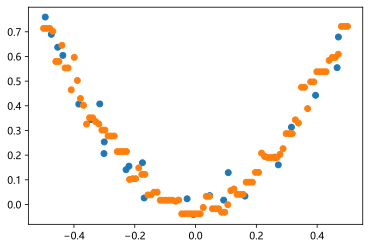

In [83]:
plt.scatter(x_val, y_val)
plt.scatter(np.linspace(-0.5, 0.5, 100), xgb_reg.predict(np.linspace(-0.5, 0.5, 100)))

# 堆叠法（stacking）

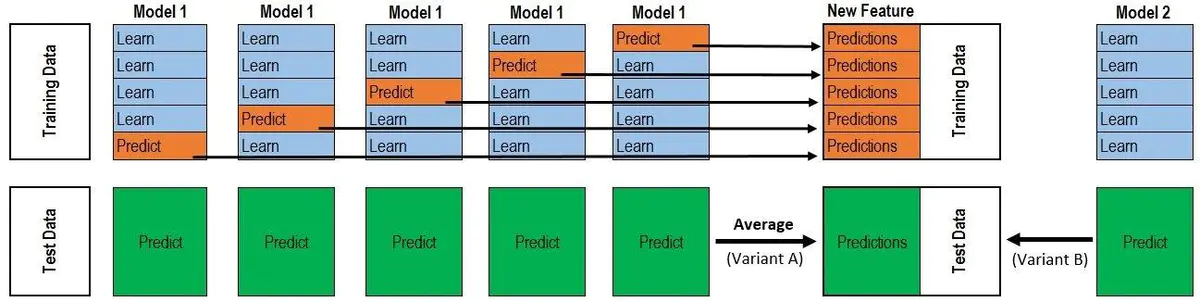

## 不同分类器一次性堆叠

In [87]:
#-*- coding:utf-8 -*-
'''
Stacking方法
'''
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings; warnings.filterwarnings(action='ignore')

#========================================================
#  载入iris数据集
#========================================================

iris = load_iris()
X = iris.data[:,:5]
y = iris.target

#========================================================
#  实现Stacking集成
#========================================================

def StackingMethod(X, y):
    '''
    Stacking方法实现分类
    INPUT -> 特征, 分类标签
    '''
    scaler = StandardScaler() # 标准化转换
    scaler.fit(X)  # 训练标准化对象
    traffic_feature= scaler.transform(X)   # 转换数据集
    feature_train, feature_test, target_train, target_test = \
                model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

    clf1 = LogisticRegression(random_state=1)
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()

    sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                              # use_probas=True, 类别概率值作为meta-classfier的输入
                              # average_probas=False,  是否对每一个类别产生的概率值做平均
                              meta_classifier=LogisticRegression())  # 综合预测模型

    sclf.fit(feature_train, target_train)

    # 模型测试
    predict_results = sclf.predict(feature_test)
    print(accuracy_score(predict_results, target_test))
    conf_mat = confusion_matrix(target_test, predict_results)
    print(conf_mat)
    print(classification_report(target_test, predict_results))

    # 5折交叉验证
    for clf, label in zip([clf1, clf2, clf3, sclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'StackingModel']):
        scores = model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

    return sclf

## 分特征堆叠

In [89]:
def StackingMethod(X, y):
    '''
    Stacking方法实现分类
    INPUT -> 特征, 分类标签
    '''
    scaler = StandardScaler() # 标准化转换
    scaler.fit(X)  # 训练标准化对象
    traffic_feature= scaler.transform(X)   # 转换数据集
    feature_train, feature_test, target_train, target_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

    pipe1 = make_pipeline(ColumnSelector(cols=(0, 1)),   # 前两个特征用一种分类器
                          LogisticRegression())
    pipe2 = make_pipeline(ColumnSelector(cols=(2, 3, 4)),  # 后两个特征用另一个分类器
                          LogisticRegression())

    sclf = StackingClassifier(classifiers=[pipe1, pipe2],
                              meta_classifier=LogisticRegression())

    sclf.fit(feature_train, target_train)

    # 模型测试
    predict_results = sclf.predict(feature_test)
    print(accuracy_score(predict_results, target_test))
    conf_mat = confusion_matrix(target_test, predict_results)
    print(conf_mat)
    print(classification_report(target_test, predict_results))

    return sclf